In [333]:
import numpy as np
from scipy import linalg
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline

# Parameter Estimation in Poisson Processes

Let $Y(t)$ be a non-homogeneous Poisson process on $[0,T]$ with a conditional intensity  $\lambda(t)$, and cumulative intensity $\Lambda(t) = \int_0^t\lambda(t)dt$. Then the number of events occuring before time $t$ follows a Poisson distribution and
$$P(Y(t)=N) = e^{-\Lambda(t) }\Lambda(t)^N/N! $$

The conditional intensity function can be written as a function of a set of covariates and parameters, for example:
$$ \lambda(t) = \exp(X(t)\beta)$$

The exponential above can be substituted with a more general 'inverse-link' function:
$$\lambda_{\beta}(t) = f(X(t)\beta)$$

We can simulate from this process:

In [334]:
N = 10000# number of observations 
d = 5 # number of covariates

1) create a vector of $d$ parameters: 

In [335]:
theta = np.random.normal(size = (d,))

2) Create an array of covariates:

In [336]:
X = 0.1*np.random.normal(size = (d,N))
# X = linalg.orth(X.T).T
# X = np.eye((d))


3) Construct the conditional intensity $\lambda(t)$

In [337]:
l = np.exp(np.dot(X.T,theta))

In [338]:
dt = 0.001 # discretization step

Generate the random variables:

In [339]:
u = np.random.uniform(size = len(l))
y = 1*(l*dt>u)

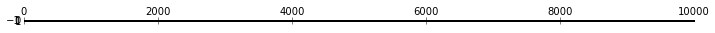

In [340]:
fig, ax = plt.subplots(figsize=(12, 2))
fig = ax.matshow(np.reshape(y,(1,len(y))),cmap = 'Greys',aspect = 3)

Given events at times $t_1,...,t_N$ the conditional likelihood is
$$P_{\beta}(t_1,...,t_N) = e^{-\Lambda(T)} \prod_{i=1}^N\lambda_{\beta}(t_i)$$.

The Maximum Likelihood Estimate for $\beta$ requires maximizing P with respect to $\beta$, but usually it  is easier to minimize the log of this function.

The corresponding negative log-likelihood is
$$ L(\beta,t_1,...,t_N) = \Lambda(T) -\sum_{i=1}^N \log(\lambda_{\beta}(t_i))$$

Now let's discretize the domain of $[0,T]$ into n bins (small enough that there is only one spike per bin) $\tau_1,...,\tau_n$. And let $y_i = 1$ if there is a spike in the bin, and $y_i = 0$ otherwise. 

$$ L(\beta,y) = \sum_{i=1}^n \lambda(\tau_i)\Delta \tau - \sum_{i=1}^n y_i \log\lambda(\tau_i)$$

In [341]:
    def negLogL(theta,X,y,dt):
        # calculate the intensity of the Poisson process
        intensity = np.exp(np.dot(X.T,theta))
        # bins with spikes vs no spikes
        l = sum(intensity)*dt - sum(y*np.log(intensity))
        return(l)


The gradient is 

$$\frac{dL}{d\beta} = \sum_{i=1}^n\frac{d\lambda(\tau_i)}{d\beta} \Delta \tau - \sum_{i=1}^n \frac{y_i}{\lambda(\tau_i)} \frac{d\lambda(\tau_i)}{ d\beta } $$

For a general link function the gradient becomes

$$ \frac{dL}{d\beta} = \sum_{i=1}^n f'(X(\tau_i)\beta)X(\tau_i)\Delta \tau - \sum_{i=1}^n \frac{y_i}{f(X(\tau_i)\beta)} f'(X(\tau_i)\beta) X(\tau_i) $$

In [342]:
    def grad(theta,X,y,dt):
        intensity = np.exp(np.dot(X.T,theta))
        g = np.dot(X,intensity)*dt - np.dot(X,y) 
        return(g) 

Set an initial guess:

In [343]:
theta_0 = np.random.normal(size = (d,))

Maximize the likelihood:

In [344]:
opts = {'disp':True,'maxiter': 1000}

In [345]:
theta_MLE = optimize.minimize(negLogL, theta_0,jac = grad, args = (X,y,dt),options = opts).x

Optimization terminated successfully.
         Current function value: 8.793364
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16


In [346]:
print ('Error: ' + str(np.sqrt(sum((theta_MLE - theta)**2))))

Error: 3.87380518036


In [347]:
theta_MLE = optimize.minimize(negLogL, theta_0, args = (X,y,dt),options = opts).x

Optimization terminated successfully.
         Current function value: 8.793364
         Iterations: 14
         Function evaluations: 105
         Gradient evaluations: 15


In [348]:
print ('Error: ' + str(np.sqrt(sum((theta_MLE - theta)**2))))

Error: 3.87386442791


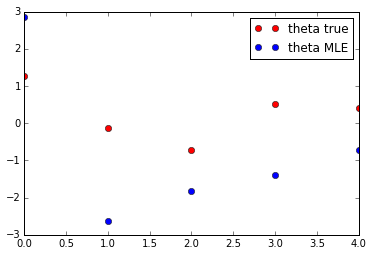

In [349]:
plt.hold(False)
plt1, = plt.plot(theta,'ro',label = 'theta true')
plt.hold(True)
plt2, = plt.plot(theta_MLE,'o',label = 'theta MLE')
plt.legend(handles = [plt1,plt2])

Calculate a prediction of the response.

In [350]:
l_MLE = np.exp(np.dot(X.T,theta_MLE))
u = np.random.uniform(size = len(l_MLE))
y_predicted = 1*(l_MLE*dt>u)

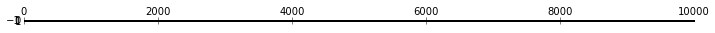

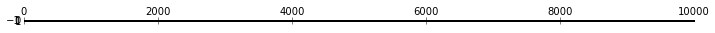

In [351]:
fig, ax = plt.subplots(figsize=(12, 2))
fig = ax.matshow(np.reshape(y,(1,len(y))),cmap = 'Greys',aspect = 3)
fig, ax = plt.subplots(figsize=(12, 2))
fig = ax.matshow(np.reshape(y_predicted,(1,len(y))),cmap = 'Greys',aspect = 3)

In [352]:
mismatch_error = sum(np.abs(y-y_predicted))/sum(y+y_predicted)
print(mismatch_error)

1.0


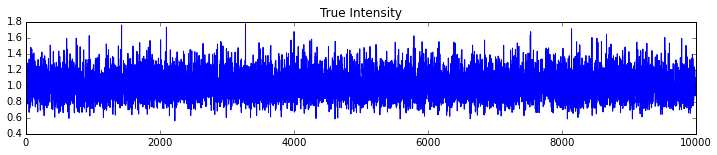

In [353]:
fig = plt.figure(figsize = (12,2))
fig = plt.plot(l)
plt.title('True Intensity')

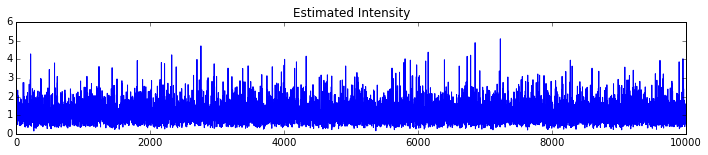

In [354]:
fig = plt.figure(figsize = (12,2))
fig = plt.plot(l_MLE)
plt.title('Estimated Intensity')